In [26]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [25]:
# Uninstall current TensorFlow version
!pip uninstall tensorflow -y

# Install a specific stable version (e.g., 2.10.0)
!pip install tensorflow==2.10.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.10.0


In [27]:
# Loading the dataset
data = pd.read_csv('/content/sample_data/twitter_training.csv')

In [28]:
data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [29]:
# Defining column names since the CSV has no header
column_names = ['id', 'entity', 'sentiment', 'content']

# Loading the dataset, specifying no header and providing column names
df = pd.read_csv('/content/sample_data/twitter_training.csv', header=None, names=column_names)

In [30]:
print(df.head())

     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                             content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [31]:
# Filter relevant sentiments (Positive, Negative, Neutral)
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]

In [32]:
# Handle missing values
df['content'] = df['content'].fillna('')

In [33]:
# Clean text data
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'@\w+|\#', '', text) # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text) # Remove special characters
    text = text.lower().strip()
    return text

In [34]:
df['content'] = df['content'].apply(clean_text)

In [35]:
# Encode sentiment labels
sentiment_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
df['sentiment'] = df['sentiment'].map(sentiment_map)

In [36]:
# Preprocessing the text data
max_words = 10000  # Maximum number of words to consider in vocabulary
max_len = 100  # Maximum length of each sequence

In [37]:
# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')

# Convert non-string values in the 'tweet' column to empty strings before fitting the tokenizer
# This handles potential NaN or other non-string entries that would cause an error
df['content'] = df['content'].astype(str).fillna('')

# Encode sentiment labels as integers for the labels variable
# This variable is used later for splitting the data and for filtering
labels = df['sentiment'].values

# Fit tokenizer on the content data
tokenizer.fit_on_texts(df['content'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['content'])

# Filter out empty sequences before padding
# An empty sequence after tokenization will be an empty list []
# We will only keep sequences that are not empty
non_empty_sequences = [seq for seq in sequences if seq]
# We also need to keep track of which original dataframe rows these non-empty sequences correspond to
# This is crucial for correctly aligning the labels.
# We can create a mask or get the indices of the non-empty sequences.
non_empty_indices = [i for i, seq in enumerate(sequences) if seq]

# Filter the original dataframe and labels based on the non-empty indices
# Use .iloc[non_empty_indices] to select the rows from the original df
df_filtered = df.iloc[non_empty_indices].copy()

# Filter the labels array using the non_empty_indices
# Note: labels was already created from the original df, so we slice it using the indices
labels_filtered = labels[non_empty_indices]

# Also filter the sentiment column for stratification
sentiment_filtered = df['sentiment'].iloc[non_empty_indices]

# Pad the non-empty sequences
padded_sequences = pad_sequences(non_empty_sequences, maxlen=max_len, padding='post', truncating='post')
# padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Check the shape of the padded sequences and filtered labels
print("Shape of padded_sequences:", padded_sequences.shape)
print("Shape of labels_filtered:", labels_filtered.shape)
print("Number of non-empty samples:", len(non_empty_sequences))


Shape of padded_sequences: (60858, 100)
Shape of labels_filtered: (60858,)
Number of non-empty samples: 60858


In [ ]:
# Encode sentiment labels
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(data['sentiment'])
# num_classes = len(label_encoder.classes_)  # Number of sentiment classes

# Encode sentiment labels
#labels = tf.keras.utils.to_categorical(df['sentiment'], num_classes=3)

In [38]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels_filtered, test_size=0.2, random_state=42, stratify=sentiment_filtered
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Training set shape: (48686, 100)
Testing set shape: (12172, 100)


In [ ]:
# RNN Model Architecture

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [40]:
# Define the RNN model architecture
embedding_dim = 100  # Dimension of word embeddings

model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len), # Embedding Layer : Converts tokenized words into dense vectors
    LSTM(128, return_sequences=False), # LSTM Layer : Captures sequential dependencies
    Dropout(0.2),  # Dropout Layer : Prevents overfitting
    Dense(64, activation='relu'), # Dense Layer : Hidden layer with ReLU activation
    Dropout(0.2), # Dropout Layer : Another dropout layer for regularization
    Dense(3, activation='softmax')  # Output layer for multi-class classification
])

print('max_words :', max_words)
print('embedding_dim :', embedding_dim)
print('max_len :', max_len)
print('num_classes :', 3)


max_words : 10000
embedding_dim : 100
max_len : 100
num_classes : 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [41]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
    optimizer='adam',
    metrics=['accuracy']
)

In [42]:
# Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 244s 197ms/step - accuracy: 0.3626 - loss: 1.0963 - val_accuracy: 0.3742 - val_loss: 1.0937
Epoch 2/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 282s 214ms/step - accuracy: 0.3628 - loss: 1.0961 - val_accuracy: 0.3742 - val_loss: 1.0935
Epoch 3/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 244s 199ms/step - accuracy: 0.3666 - loss: 1.0953 - val_accuracy: 0.3742 - val_loss: 1.0935
Epoch 4/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 270s 206ms/step - accuracy: 0.3645 - loss: 1.0948 - val_accuracy: 0.3742 - val_loss: 1.0938
Epoch 5/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 264s 208ms/step - accuracy: 0.3608 - loss: 1.0958 - val_accuracy: 0.3742 - val_loss: 1.0929
Epoch 6/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 257s 204ms/step - accuracy: 0.3575 - loss: 1.0967 - val_accuracy: 0.3742 - val_loss: 1.0928
Epoch 7/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 255s 209ms/step - accuracy: 0.3634 - loss: 1.0954 - val_accuracy: 0.3742 - val_loss: 1.0930
Epoch 8/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 240s 197ms/step - ac

In [43]:
# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,377,099 (12.88 MB)

 Trainable params: 1,125,699 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,251,400 (8.59 MB)

In [46]:
# 5. Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# y_test_classes = np.argmax(y_test, axis=1) # Original line causing error
y_test_classes = y_test # Assign y_test directly, as it already contains the true class labels

381/381 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step


In [47]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Positive', 'Negative', 'Neutral']))


Classification Report:
              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00      4119
    Negative       0.37      1.00      0.54      4453
     Neutral       0.00      0.00      0.00      3600

    accuracy                           0.37     12172
   macro avg       0.12      0.33      0.18     12172
weighted avg       0.13      0.37      0.20     12172



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
''''
Above classicication report indicates that the current model is not performing correctly, it seems its biased to Negative
''''

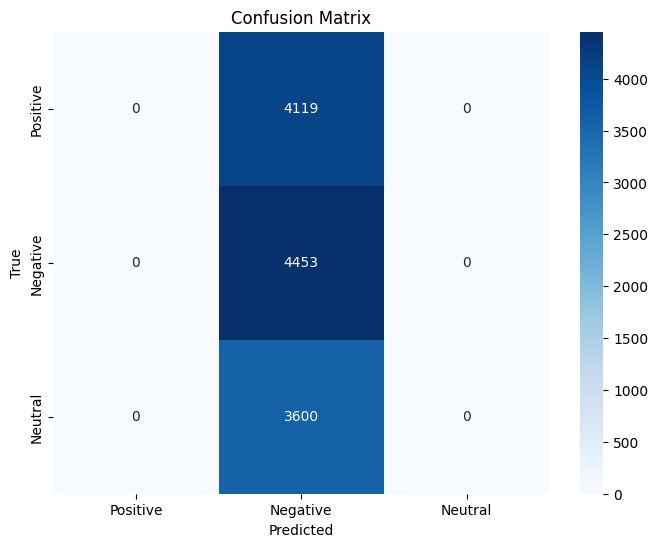

In [48]:
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

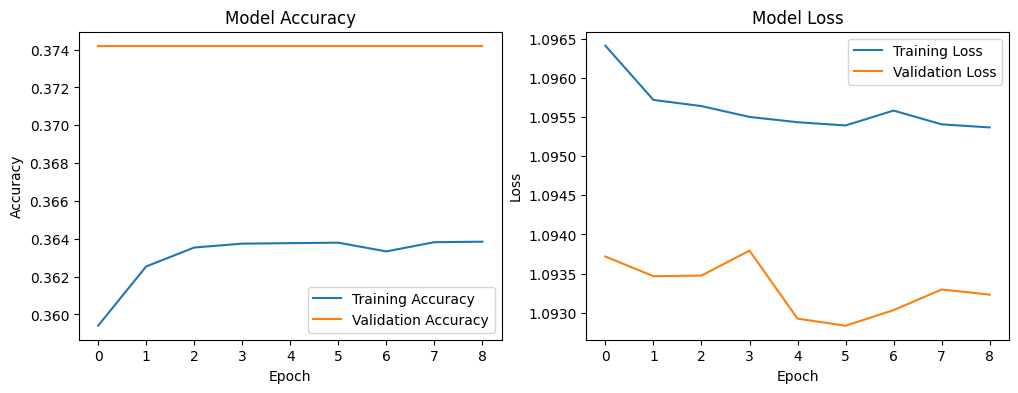

In [49]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()